# Purpose of this
The purpose of this isto compare/benchmark a few different stitch performance metrics for OLS vs. Gradient Descent. If we can find a way to do OLS instead of GD then we could in principle do this a lot faster. The notebook here basically confirms that indeed OLS is much faster than GD and that for our problems it performs equally well if not way better. This means we should switch to OLS, which could give us a massive boost in runtime. We also experiment with how much faster batched OLS is in the bottom. The goal is to find the fast possible way to get a great stitch, measured by MSE.

## The conclusion from this is that:
- OLS is at least at GD. It _might_ be superior. They seem to approximate eachother NGL.
- OLS is faster by a LOT (i.e. we might get 10-1000x speedup).

In [1]:
device = "cuda:0"

In [35]:
import torch
import time
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from typing import Tuple

def ordinary_least_squares(X, Y, affine=True, mean_centering=True) -> Tuple[float, torch.Tensor, torch.Tensor]:
    """ Return error. """
    assert len(X.shape) == 2
    assert len(Y.shape) == 2
    assert X.shape[0] == Y.shape[0]
    if affine:
        X_affine = torch.cat([X, torch.ones(X.shape[0], 1).to(device)], dim=1)
        assert len(X_affine.shape) == 2
        assert X_affine.shape[0] == X.shape[0]
        assert X_affine.shape[1] == X.shape[1] + 1
        XT = torch.t(X_affine)
        XTX = torch.mm(XT, X_affine)
        XTX_inv = torch.inverse(XTX)
        XTY = torch.mm(XT, Y)
        coeffs = torch.mm(XTX_inv, XTY).squeeze()
        # Split into weights and bias
        weights = coeffs[:-1]
        bias = coeffs[-1]
        err = (Y - (X @ weights) - bias).pow(2).mean().item()
        return err, weights, bias
    else:
        X_mean = X.mean(dim=0)
        Y_mean = Y.mean(dim=0)
        if not mean_centering:
            X_mean = torch.zeros(X.shape[1]).to(device)
            Y_mean = torch.zeros(Y.shape[1]).to(device)
        X_centered = X - X_mean
        Y_centered = Y - Y_mean

        XT = torch.t(X_centered)
        XTX = torch.mm(XT, X_centered)
        XTX_inv = torch.inverse(XTX)
        XTY = torch.mm(XT, Y_centered)
        beta = torch.mm(XTX_inv, XTY)

        Y_pred = torch.mm(X_centered, beta) + Y_mean
        err = (Y_pred - Y).pow(2).mean().item()
        return err, beta, (Y_mean - (X_mean @ beta))

class EmbeddingDataset(Dataset):
    def __init__(self, source_embeddings: torch.Tensor, target_embeddings: torch.Tensor):
        assert source_embeddings.shape[0] == target_embeddings.shape[0]
        self.source_embeddings = source_embeddings
        self.target_embeddings = target_embeddings
        
    def __len__(self):
        return len(self.source_embeddings)
        
    def __getitem__(self, idx):
        return self.source_embeddings[idx], self.target_embeddings[idx]

def gradient_descent(X, Y, affine=True):
    """ Return error. """
    linear = nn.Linear(X.shape[1], Y.shape[1], bias=affine).to(device)
    num_epochs=50
    batch_size=32
    learning_rate=0.001

    # dataset and dataloader
    train_dataset = EmbeddingDataset(X, Y)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(linear.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    for _ in range(num_epochs):
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = linear(X_batch)
            loss = loss_fn(y_pred, Y_batch)
            loss.backward()
            optimizer.step()
    Y_pred = linear(X)
    err = (Y_pred - Y).pow(2).mean().item()
    assert len(list(linear.parameters())) in [1, 2]
    return err, linear.weight, (linear.bias if affine else torch.zeros(Y.shape[1]).to(device))


def solve_ols_of_size(n_samples: int, n_feature_size: int, affine: bool = True) -> tuple[float, float]:
    X = torch.randn(n_samples, n_feature_size).to(device)
    Y = torch.randn(n_samples, n_feature_size).to(device)
    start_time = time.time()
    err, _, _ = ordinary_least_squares(X, Y, affine=affine)
    end_time = time.time()
    return err, end_time - start_time

def solve_gradient_descent_of_size(n_samples: int, n_feature_size: int, affine: bool = True) -> tuple[float, float]:
    X = torch.randn(n_samples, n_feature_size).to(device)
    Y = torch.randn(n_samples, n_feature_size).to(device)
    start_time = time.time()
    err, _, _ = gradient_descent(X, Y, affine=affine)
    end_time = time.time()
    return err, end_time - start_time


In [3]:
import tqdm
from typing import List, Tuple
errs_times_ols: List[Tuple[float, float]] = [
    solve_ols_of_size(size, 2048)
    for size in tqdm.trange(200, 20_000, 200)
]
errs_times_ols_no_affine: List[Tuple[float, float]] = [
    solve_ols_of_size(size, 2048, affine=False)
    for size in tqdm.trange(200, 20_000, 200)
]

100%|██████████| 99/99 [00:23<00:00,  4.23it/s]


In [4]:
errs_times_gradient_descent: List[Tuple[float, float]] = [
    solve_gradient_descent_of_size(size, 2048)
    for size in tqdm.trange(200, 10_000, 200) # scales very badly actually :( - to finish in time I shortened it
]

  0%|          | 0/49 [00:00<?, ?it/s]

AssertionError: 

In [7]:
errs_times_gradient_descent_no_affine: List[Tuple[float, float]] = [
    solve_gradient_descent_of_size(size, 2048, affine=False)
    for size in tqdm.trange(200, 10_000, 200) # scales very badly actually :( - to finish in time I shortened it
]



















































100%|██████████| 49/49 [03:55<00:00,  4.81s/it]


  0%|          | 0/49 [08:03<?, ?it/s]


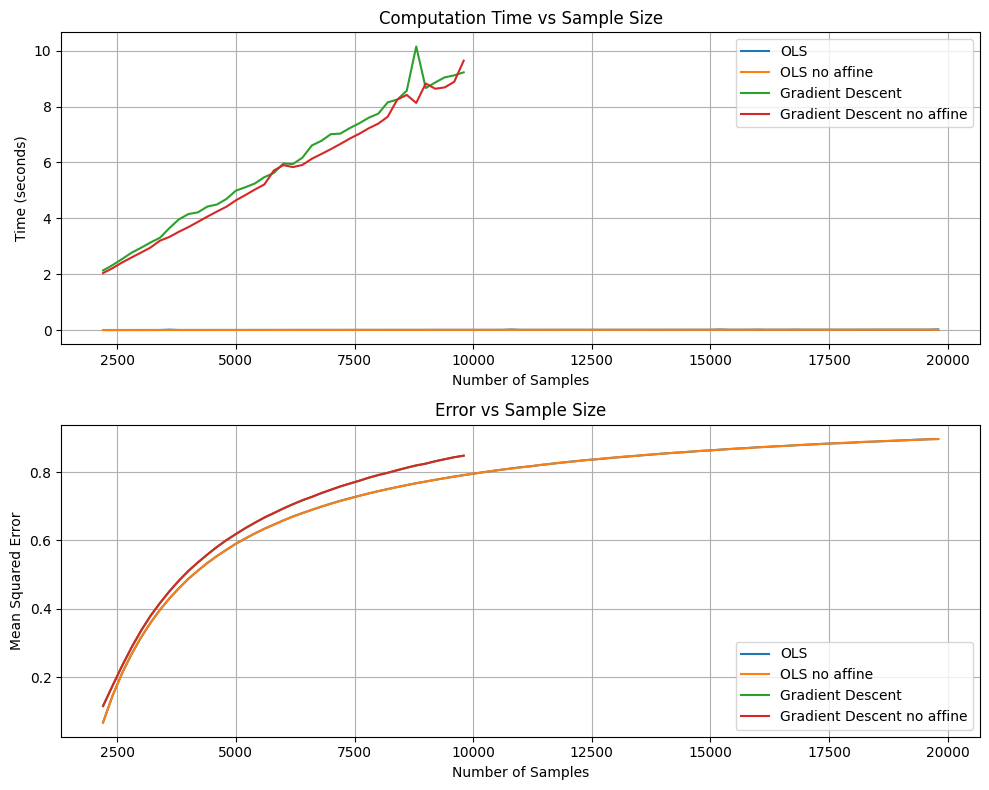

In [9]:
from matplotlib import pyplot as plt

# plot the times taken
# Extract times and errors
times_ols = [t for _, t in errs_times_ols][10:] # early ones are wierd
times_ols_no_affine = [t for _, t in errs_times_ols_no_affine][10:] # early ones are wierd
times_gd = [t for _, t in errs_times_gradient_descent][10:] # early ones are wierd
times_gd_no_affine = [t for _, t in errs_times_gradient_descent_no_affine][10:] # early ones are wierd
errs_ols = [e for e, _ in errs_times_ols][10:] # early ones are wierd
errs_ols_no_affine = [e for e, _ in errs_times_ols_no_affine][10:] # early ones are wierd
errs_gd = [e for e, _ in errs_times_gradient_descent][10:] # early ones are wierd
errs_gd_no_affine = [e for e, _ in errs_times_gradient_descent_no_affine][10:] # early ones are wierd

# Create x-axis values
sizes_ols = list(range(200, 20_000, 200))[10:] # ^
sizes_ols_no_affine = list(range(200, 20_000, 200))[10:] # ^
sizes_gd = list(range(200, 10_000, 200))[10:] # ^
sizes_gd_no_affine = list(range(200, 10_000, 200))[10:] # ^

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot times
ax1.plot(sizes_ols, times_ols, label='OLS')
ax1.plot(sizes_ols_no_affine, times_ols_no_affine, label='OLS no affine')
ax1.plot(sizes_gd, times_gd, label='Gradient Descent')
ax1.plot(sizes_gd_no_affine, times_gd_no_affine, label='Gradient Descent no affine')
ax1.set_xlabel('Number of Samples')
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Computation Time vs Sample Size')
ax1.legend()
ax1.grid(True)

# Plot errors
ax2.plot(sizes_ols, errs_ols, label='OLS')
ax2.plot(sizes_ols_no_affine, errs_ols_no_affine, label='OLS no affine')
ax2.plot(sizes_gd, errs_gd, label='Gradient Descent')
ax2.plot(sizes_gd_no_affine, errs_gd_no_affine, label='Gradient Descent no affine')
ax2.set_xlabel('Number of Samples')
ax2.set_ylabel('Mean Squared Error')
ax2.set_title('Error vs Sample Size')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()





In [36]:
from pathlib import Path
from safetensors.torch import load_file
def sanity_ols_mse(embeddings1_path: Path, embeddings2_path: Path):
    # work only on corpus right now
    embeddings1_train = load_file(embeddings1_path / "embeddings_corpus_train.safetensors")["embeddings"].to(device) # X
    embeddings1_validation = load_file(embeddings1_path / "embeddings_corpus_validation.safetensors")["embeddings"].to(device) # Y
    embeddings2_train = load_file(embeddings2_path / "embeddings_corpus_train.safetensors")["embeddings"].to(device) # x
    embeddings2_validation = load_file(embeddings2_path / "embeddings_corpus_validation.safetensors")["embeddings"].to(device) # y
    assert embeddings1_train.shape[0] == embeddings2_train.shape[0]
    assert embeddings1_validation.shape[0] == embeddings2_validation.shape[0]

    # Train both models
    time_start = time.time()
    err_ols, beta_ols, bias_ols = ordinary_least_squares(embeddings1_train, embeddings2_train)
    time_ols = time.time() - time_start
    time_start = time.time()
    err_ols_no_affine, beta_ols_no_affine, bias_ols_no_affine = ordinary_least_squares(embeddings1_train, embeddings2_train, affine=False)
    time_ols_no_affine = time.time() - time_start
    time_start = time.time()
    err_gd, beta_gd, bias_gd = gradient_descent(embeddings1_train, embeddings2_train, affine=True)
    time_gd = time.time() - time_start
    time_start = time.time()
    err_gd_no_affine, beta_gd_no_affine, bias_gd_no_affine = gradient_descent(embeddings1_train, embeddings2_train, affine=False)
    time_gd_no_affine = time.time() - time_start
    print("="*100)
    print("err_ols", err_ols)
    print("err_ols_no_affine", err_ols_no_affine)
    print("err_gd", err_gd)
    print("err_gd_no_affine", err_gd_no_affine)
    print("="*100)
    print("time_ols", time_ols)
    print("time_ols_no_affine", time_ols_no_affine)
    print("time_gd", time_gd)
    print("time_gd_no_affine", time_gd_no_affine)
    print("="*100)
    assert len(beta_ols.shape) == 2
    assert len(beta_ols_no_affine.shape) == 2
    assert len(beta_gd.shape) == 2
    assert len(beta_gd_no_affine.shape) == 2
    if beta_ols.shape != (embeddings1_train.shape[1], embeddings2_train.shape[1]):
        beta_ols = beta_ols.reshape(embeddings1_train.shape[1], embeddings2_train.shape[1])
    if beta_ols_no_affine.shape != (embeddings1_train.shape[1], embeddings2_train.shape[1]):
        beta_ols_no_affine = beta_ols_no_affine.reshape(embeddings1_train.shape[1], embeddings2_train.shape[1])
    if beta_gd.shape != (embeddings1_train.shape[1], embeddings2_train.shape[1]):
        beta_gd = beta_gd.reshape(embeddings1_train.shape[1], embeddings2_train.shape[1])
    if beta_gd_no_affine.shape != (embeddings1_train.shape[1], embeddings2_train.shape[1]):
        beta_gd_no_affine = beta_gd_no_affine.reshape(embeddings1_train.shape[1], embeddings2_train.shape[1])

    # Calculate predictions
    assert beta_ols.shape == (embeddings1_train.shape[1], embeddings2_train.shape[1]), f"beta_ols.shape: {beta_ols.shape} != (embeddings1_train.shape[1], embeddings2_train.shape[1]): {embeddings1_train.shape[1]}, {embeddings2_train.shape[1]}"
    assert beta_ols_no_affine.shape == (embeddings1_train.shape[1], embeddings2_train.shape[1]), f"beta_ols_no_affine.shape: {beta_ols_no_affine.shape} != (embeddings1_train.shape[1], embeddings2_train.shape[1]): {embeddings1_train.shape[1]}, {embeddings2_train.shape[1]}"
    assert beta_gd.shape == (embeddings1_train.shape[1], embeddings2_train.shape[1]), f"beta_gd.shape: {beta_gd.shape} != (embeddings1_train.shape[1], embeddings2_train.shape[1]): {embeddings1_train.shape[1]}, {embeddings2_train.shape[1]}"
    assert beta_gd_no_affine.shape == (embeddings1_train.shape[1], embeddings2_train.shape[1]), f"beta_gd_no_affine.shape: {beta_gd_no_affine.shape} != (embeddings1_train.shape[1], embeddings2_train.shape[1]): {embeddings1_train.shape[1]}, {embeddings2_train.shape[1]}"
    assert bias_ols.shape == (embeddings2_train.shape[1],), f"bias_ols.shape: {bias_ols.shape} != (embeddings2_train.shape[1],): {embeddings2_train.shape[1]}"
    assert bias_ols_no_affine.shape == (embeddings2_train.shape[1],), f"bias_ols_no_affine.shape: {bias_ols_no_affine.shape} != (embeddings2_train.shape[1],): {embeddings2_train.shape[1]}"
    assert bias_gd.shape == (embeddings2_train.shape[1],), f"bias_gd.shape: {bias_gd.shape} != (embeddings2_train.shape[1],): {embeddings2_train.shape[1]}"
    assert bias_gd_no_affine.shape == (embeddings2_train.shape[1],), f"bias_gd_no_affine.shape: {bias_gd_no_affine.shape} != (embeddings2_train.shape[1],): {embeddings2_train.shape[1]}"
    preds_ols_train = embeddings1_train @ beta_ols + bias_ols
    preds_gd_train = embeddings1_train @ beta_gd + bias_gd
    preds_ols_validation = embeddings1_validation @ beta_ols + bias_ols
    preds_gd_validation = embeddings1_validation @ beta_gd + bias_gd
    preds_ols_validation_no_affine = embeddings1_validation @ beta_ols_no_affine
    preds_gd_validation_no_affine = embeddings1_validation @ beta_gd_no_affine

    # Calculate MSE for both models
    mse_ols_train = torch.mean((preds_ols_train - embeddings2_train) ** 2).item()
    mse_gd_train = torch.mean((preds_gd_train - embeddings2_train) ** 2).item()
    mse_ols_validation = torch.mean((preds_ols_validation - embeddings2_validation) ** 2).item()
    mse_gd_validation = torch.mean((preds_gd_validation - embeddings2_validation) ** 2).item()
    mse_ols_validation_no_affine = torch.mean((preds_ols_validation_no_affine - embeddings2_validation) ** 2).item()
    mse_gd_validation_no_affine = torch.mean((preds_gd_validation_no_affine - embeddings2_validation) ** 2).item()

    print("="*100)
    print(f"[Expect low] MSE for OLS: {mse_ols_train:.6f}")
    print(f"[Expect low] MSE for Gradient Descent: {mse_gd_train:.6f}")
    print(f"[Expect low] MSE for OLS validation: {mse_ols_validation:.6f}")
    print(f"[Expect low] MSE for Gradient Descent validation: {mse_gd_validation:.6f}")
    print(f"[Expect low] MSE for OLS validation no affine: {mse_ols_validation_no_affine:.6f}")
    print(f"[Expect low] MSE for Gradient Descent validation no affine: {mse_gd_validation_no_affine:.6f}")
    print("="*100)

    # Calculate distance between weights and biases
    weight_dist = torch.mean((beta_ols - beta_gd) ** 2).item()
    bias_dist = torch.mean((bias_ols - bias_gd) ** 2).item()
    weight_dist_no_affine = torch.mean((beta_ols_no_affine - beta_gd_no_affine) ** 2).item()
    bias_dist_no_affine = torch.mean((bias_ols_no_affine - bias_gd_no_affine) ** 2).item()
    _random_distances = []
    _random_bias_distances = []
    _random_distances_no_affine = []
    _random_bias_distances_no_affine = []
    for _ in range(20):
        _random_weights = torch.randn(embeddings1_train.shape[1], embeddings2_train.shape[1]).to(device)
        _random_bias = torch.randn(embeddings2_train.shape[1]).to(device)
        _random_distances.append(torch.mean((_random_weights - beta_ols) ** 2).item())
        _random_distances_no_affine.append(torch.mean((_random_weights - beta_ols_no_affine) ** 2).item())
        _random_bias_distances.append(torch.mean((_random_bias - bias_ols) ** 2).item())
        _random_bias_distances_no_affine.append(torch.mean((_random_bias - bias_ols_no_affine) ** 2).item())
    _random_distances = torch.tensor(_random_distances)
    _random_distances_min, _random_distances_max, _random_distances_mean, _random_distances_std = _random_distances.min().item(), _random_distances.max().item(), _random_distances.mean().item(), _random_distances.std().item() # fmt: skip
    _random_bias_distances = torch.tensor(_random_bias_distances)
    _random_bias_distances_min, _random_bias_distances_max, _random_bias_distances_mean, _random_bias_distances_std = _random_bias_distances.min().item(), _random_bias_distances.max().item(), _random_bias_distances.mean().item(), _random_bias_distances.std().item() # fmt: skip
    _random_distances_no_affine = torch.tensor(_random_distances_no_affine)
    _random_distances_no_affine_min, _random_distances_no_affine_max, _random_distances_no_affine_mean, _random_distances_no_affine_std = _random_distances_no_affine.min().item(), _random_distances_no_affine.max().item(), _random_distances_no_affine.mean().item(), _random_distances_no_affine.std().item() # fmt: skip
    _random_bias_distances_no_affine = torch.tensor(_random_bias_distances_no_affine)
    _random_bias_distances_no_affine_min, _random_bias_distances_no_affine_max, _random_bias_distances_no_affine_mean, _random_bias_distances_no_affine_std = _random_bias_distances_no_affine.min().item(), _random_bias_distances_no_affine.max().item(), _random_bias_distances_no_affine.mean().item(), _random_bias_distances_no_affine.std().item() # fmt: skip
    print("="*100)
    print(f"\nMean squared distance between:")
    print(f"[Expect low] Weights: {weight_dist:.6f}")
    print(f"[Expect low] Biases: {bias_dist:.6f}")
    print(f"[Expect low] Weights no affine: {weight_dist_no_affine:.6f}")
    print(f"[Expect low] Biases no affine: {bias_dist_no_affine:.6f}")
    print(f"[Expect high] Random weights: {_random_distances_min:.6f} < {_random_distances_mean:.6f} +/- {_random_distances_std:.6f} < {_random_distances_max:.6f}")
    print(f"[Expect high] Random biases: {_random_bias_distances_min:.6f} < {_random_bias_distances_mean:.6f} +/- {_random_bias_distances_std:.6f} < {_random_bias_distances_max:.6f}")
    print(f"[Expect high] Random weights no affine: {_random_distances_no_affine_min:.6f} < {_random_distances_no_affine_mean:.6f} +/- {_random_distances_no_affine_std:.6f} < {_random_distances_no_affine_max:.6f}")
    print(f"[Expect high] Random biases no affine: {_random_bias_distances_no_affine_min:.6f} < {_random_bias_distances_no_affine_mean:.6f} +/- {_random_bias_distances_no_affine_std:.6f} < {_random_bias_distances_no_affine_max:.6f}")
    print("="*100)



In [37]:
# random pair 1
embeddings1_path = Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings_huggingface/intfloat_e5-base-v2/arguana")
embeddings2_path = Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings_huggingface/thenlper_gte-base/arguana")
sanity_ols_mse(embeddings1_path, embeddings2_path)

err_ols 8.714398427400738e-05
err_ols_no_affine 8.385876571992412e-05
err_gd 9.679009235696867e-05
err_gd_no_affine 9.624120139051229e-05
time_ols 0.004077434539794922
time_ols_no_affine 0.0035762786865234375
time_gd 9.00365138053894
time_gd_no_affine 8.587525367736816
[Expect low] MSE for OLS: 0.000087
[Expect low] MSE for Gradient Descent: 0.001777
[Expect low] MSE for OLS validation: 0.000105
[Expect low] MSE for Gradient Descent validation: 0.001776
[Expect low] MSE for OLS validation no affine: 0.002458
[Expect low] MSE for Gradient Descent validation no affine: 0.001549

Mean squared distance between:
[Expect low] Weights: 0.006846
[Expect low] Biases: 0.001987
[Expect low] Weights no affine: 0.006672
[Expect low] Biases no affine: 0.002356
[Expect high] Random weights: 1.003405 < 1.006143 +/- 0.001507 < 1.009459
[Expect high] Random biases: 0.927924 < 1.018746 +/- 0.060413 < 1.139529
[Expect high] Random weights no affine: 1.003220 < 1.005957 +/- 0.001502 < 1.009288
[Expect high

In [38]:
# random pair 2
embeddings1_path = Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings_huggingface/mixedbread-ai_mxbai-embed-large-v1/hotpotqa")
embeddings2_path = Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings_huggingface/WhereIsAI_UAE-Large-V1/hotpotqa")
sanity_ols_mse(embeddings1_path, embeddings2_path)

err_ols 0.00012953538680449128
err_ols_no_affine 2.916907078542863e-06
err_gd 5.826483175042085e-06
err_gd_no_affine 5.0575617933645844e-06
time_ols 0.007892370223999023
time_ols_no_affine 0.007428407669067383
time_gd 21.549910306930542
time_gd_no_affine 19.69837737083435
[Expect low] MSE for OLS: 0.000130
[Expect low] MSE for Gradient Descent: 0.000096
[Expect low] MSE for OLS validation: 0.000130
[Expect low] MSE for Gradient Descent validation: 0.000096
[Expect low] MSE for OLS validation no affine: 0.000070
[Expect low] MSE for Gradient Descent validation no affine: 0.000084

Mean squared distance between:
[Expect low] Weights: 0.000862
[Expect low] Biases: 0.002614
[Expect low] Weights no affine: 0.001064
[Expect low] Biases no affine: 0.000067
[Expect high] Random weights: 0.998754 < 1.001673 +/- 0.001373 < 1.003691
[Expect high] Random biases: 0.888445 < 0.988698 +/- 0.060054 < 1.087076
[Expect high] Random weights no affine: 0.998878 < 1.001857 +/- 0.001380 < 1.003943
[Expect h

In [39]:
# Try a reversal - random pair 3
embeddings1_path = Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings_huggingface/WhereIsAI_UAE-Large-V1/hotpotqa")
embeddings2_path = Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings_huggingface/mixedbread-ai_mxbai-embed-large-v1/hotpotqa")
sanity_ols_mse(embeddings1_path, embeddings2_path)

err_ols 4.66822566522751e-05
err_ols_no_affine 2.4332762222911697e-06
err_gd 5.329978648660472e-06
err_gd_no_affine 5.5018276725604665e-06
time_ols 0.007926225662231445
time_ols_no_affine 0.007411003112792969
time_gd 20.478193521499634
time_gd_no_affine 20.03372359275818
[Expect low] MSE for OLS: 0.000047
[Expect low] MSE for Gradient Descent: 0.000100
[Expect low] MSE for OLS validation: 0.000047
[Expect low] MSE for Gradient Descent validation: 0.000101
[Expect low] MSE for OLS validation no affine: 0.000055
[Expect low] MSE for Gradient Descent validation no affine: 0.000104

Mean squared distance between:
[Expect low] Weights: 0.000361
[Expect low] Biases: 0.000077
[Expect low] Weights no affine: 0.000803
[Expect low] Biases no affine: 0.000052
[Expect high] Random weights: 0.999631 < 1.001328 +/- 0.001112 < 1.004054
[Expect high] Random biases: 0.956850 < 1.009395 +/- 0.038352 < 1.073063
[Expect high] Random weights no affine: 1.000049 < 1.001758 +/- 0.001124 < 1.004539
[Expect hi

In [40]:
# random pair 4
embeddings1_path = Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings_huggingface/BAAI_bge-large-en-v1.5/nfcorpus")
embeddings2_path = Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings_huggingface/sentence-transformers_sentence-t5-base/nfcorpus")
sanity_ols_mse(embeddings1_path, embeddings2_path)



err_ols 0.0007396980072371662
err_ols_no_affine 6.8967419792898e-05
err_gd 7.642907439731061e-05
err_gd_no_affine 7.511844887631014e-05
time_ols 0.004654884338378906
time_ols_no_affine 0.004322528839111328
time_gd 5.475717067718506
time_gd_no_affine 5.257530689239502
[Expect low] MSE for OLS: 0.000740
[Expect low] MSE for Gradient Descent: 0.001619
[Expect low] MSE for OLS validation: 0.000785
[Expect low] MSE for Gradient Descent validation: 0.001619
[Expect low] MSE for OLS validation no affine: 0.017322
[Expect low] MSE for Gradient Descent validation no affine: 0.002134

Mean squared distance between:
[Expect low] Weights: 0.010974
[Expect low] Biases: 0.001486
[Expect low] Weights no affine: 0.327927
[Expect low] Biases no affine: 0.017203
[Expect high] Random weights: 1.008166 < 1.010012 +/- 0.001264 < 1.012276
[Expect high] Random biases: 0.896703 < 0.998456 +/- 0.043353 < 1.116422
[Expect high] Random weights no affine: 1.323278 < 1.326594 +/- 0.001855 < 1.329938
[Expect high] 

In [41]:
# random pair 5 -> do same for comparison across dataset
embeddings1_path = Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings_huggingface/BAAI_bge-large-en-v1.5/scidocs")
embeddings2_path = Path("/mnt/align3_drive/adrianoh/dl_final_project_embeddings_huggingface/sentence-transformers_sentence-t5-base/scidocs")
sanity_ols_mse(embeddings1_path, embeddings2_path)



err_ols 0.026486339047551155
err_ols_no_affine 9.058238356374204e-05
err_gd 0.00010933166049653664
err_gd_no_affine 0.00011166060721734539
time_ols 0.008299589157104492
time_ols_no_affine 0.007755756378173828
time_gd 26.15443205833435
time_gd_no_affine 25.246981859207153
[Expect low] MSE for OLS: 0.026486
[Expect low] MSE for Gradient Descent: 0.001036
[Expect low] MSE for OLS validation: 0.026561
[Expect low] MSE for Gradient Descent validation: 0.001036
[Expect low] MSE for OLS validation no affine: 0.002888
[Expect low] MSE for Gradient Descent validation no affine: 0.002001

Mean squared distance between:
[Expect low] Weights: 0.475802
[Expect low] Biases: 0.094080
[Expect low] Weights no affine: 0.038520
[Expect low] Biases no affine: 0.002791
[Expect high] Random weights: 1.471730 < 1.475645 +/- 0.002552 < 1.480662
[Expect high] Random biases: 0.909500 < 1.065004 +/- 0.066251 < 1.185946
[Expect high] Random weights no affine: 1.034922 < 1.038237 +/- 0.001813 < 1.041039
[Expect hi

In [ ]:
# TODO(Adriano) batch (also could we try ridge regression or something to reduce the overfitting?)